# Árboles de decisión

#### Criterio de selección de particiones: Entropía (método C4.5)
 
$$\Large S = -\sum_{i=1}^{C}p_i \log_2{p_i}$$

La entropía muestra el grado de "mezcla" entre $C$ clases. Donde $p_i$ es la probabilidad de cada clase $i$. Por ejemplo aquí tenemos 2 clases con una entropía muy alta.
![dtree1](img/dtree1.png)

Tenemos $9$ bolas azules y $11$ amarillas. Si aleatoriamente cogemos una bola. las probabilidades son $p_{azul}= \frac{9}{20},  p_{amarillo}=\frac{11}{20}$. Lo cual nos da una entropía de:


$$S = - \left( \frac{9}{20}\log_2{\frac{9}{20}} \right) -
          \left( \frac{11}{20}\log_2{\frac{11}{20}} \right) = 0.9927 \approx 1$$

> #### Extra: Entropy vs Gini
> A parte de la entropía para calcular el grado de desorden de un nodo, existe otra medida llamada **Gini**.
> $$ Entropía = -\sum_{i=1}^{C} p_i \log_2{p_i}$$
> $$ Gini  = 1 - \sum_{i=1}^{C} (p_i)^2$$
>
> Ambas funcionan de manera parecida.

In [104]:
from math import log, pow

p1, p2 = 9/20, 11/20
entrop = - (p1 * log(p1,2)) - (p2 * log(p2,2))
gini   = 1 - pow(p1, 2) - pow(p2, 2)
print("Muy mezclado:\n\tEntropía:",entrop,"\n\tGini:    ",gini)

p1, p2 = 1/20, 19/20
entrop = - (p1 * log(p1,2)) - (p2 * log(p2,2))
gini   = 1 - pow(p1, 2) - pow(p2, 2)
print("Poco mezclado:\n\tEntropía:",entrop,"\n\tGini:    ",gini)

Muy mezclado:
	Entropía: 0.9927744539878084 
	Gini:     0.49499999999999994
Poco mezclado:
	Entropía: 0.28639695711595625 
	Gini:     0.09500000000000008


La entropía puede tomar valores de $[0,1]$, donde valores cercanos al $0$ indican que hay una clase dominante y por lo tanto poco caos. Y una entropía cercana a $1$ indica que hay muchas clases con probabilidades similares, es decir, caos y desorden.

La entropía la usaremos para comparar la partición padre con las particiones hijas.

![dtree2](img/dtree2.png)

Si las particiones hijas tienen menos entropía, son buenas. Veamoslas. La partición de la izquierda tiene 13 bolas, 8 azules y 5 amarillas:

$$S_1 = -\frac{5}{13}\log_2{\frac{5}{13}}-\frac{8}{13}\log_2{\frac{8}{13}} \approx 0.96$$

La partición de la derecha tiene 7 bolas, 1 azul y 6 amarillas.

$$S_2 = -\frac{1}{7}\log_2{\frac{1}{7}}-\frac{6}{7}\log_2{\frac{6}{7}} \approx 0.6$$

Vemos que la entropía ha disminuido en ambos grupos, (bastante más en la izquierda). La reducción de la entropía se llama **ganancia de información**. Pero no podemos hacer simplemente una media de las particiones hijas para compararla con la padre. Debemos ponderarlas acore al numero de muestras de cada una. La fórmula de ganancia es la siguiente:

$$\Large GI(Q) = S_{padre} - \sum_{i=1}^{\normalsize numHijos}\frac{N_i}{N}S_i$$

La variable $Q$ indica por dónde estamos particionando al padre, en este ejemplo es "$x\leq12$".

- Número de muestras de la partición padre: $N = 20$
- Número de muestras de las particiones hijas: $N_1 = 13, N_2 = 7 $

$$ \Large GI(x \leq 12) = S_{padre} - \normalsize \left( \left( \frac{13}{20}S_1 \right) + \left( \frac{7}{20}S_2 \right) \right) \approx 0.16$$

Al final nos quedaremos con la partición (sitio de cortar al padre) que más gananacia de información nos de. En este caso cortar por $12.5$ nos da una ganancia de $0.16$, si repetimos el proceso quedaría un árbol como este.

![dtree3](img/dtree3.png)

Fijarse que si en un nodo ya no hay ganancia de información, como aquellos donde todos los ejemplos son de la misama clase, ya no se particiona, será un nodo hoja.


## Parte 2: La poda del árbol

Si obtenemos un árbol que segmenta a la perfeción nuestro conjunto de entrenamiento, lo que estamos haciendo es memorizar nuestros datos y **overfitting**. Caundo llegen nuevos datos seguramente lo hagamos mal. Es preferible tener árboles más pequeños con menos ramas porque generalizan mejor.

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [42]:
# MODELS
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# OTHERS
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# METRICS
from sklearn.metrics import accuracy_score

# DRAW TREES
import pydotplus
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

In [18]:
df = pd.read_csv('data/telecom_churn.csv')
df.head(n=3)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [19]:
##### Convert to numbers
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan']    = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')

df.drop(['State'], axis=1, inplace=True) # We dont use this categoriacl feat

x = df.drop(['Churn'], axis=1)
y = df['Churn'] # This is the target

x.shape, y.shape

((3333, 18), (3333,))

#### Shuffled stratified 30% validation set

In [27]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=17)
print("Train:", x_train.shape, y_train.shape)
print("Valid:", x_valid.shape, y_valid.shape)

Train: (2333, 18) (2333,)
Valid: (1000, 18) (1000,)


#### Train DecisionTree and KNeighbors

In [30]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(x_train, y_train)
knn.fit(x_train_scaled, y_train)  # for kNN, we need to scale features

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [33]:
tree_pred = tree.predict(x_valid)
accuracy_score(y_valid, tree_pred) # 0.94

0.94

In [34]:
knn_pred = knn.predict(x_valid_scaled)
accuracy_score(y_valid, knn_pred) # 0.89

0.89

Now, let's identify the parameters for the tree using cross-validation. We'll tune the maximum depth and the maximum number of features used at each split. Here is the essence of how the GridSearchCV works: for each unique pair of values of `max_depth` and `max_features`, compute model performance with 5-fold cross-validation, and then select the best combination of parameters.

In [111]:
tree_params = {'criterion':    ["entropy", "gini"],
               'max_depth':    range(3,13), # Maybe up to 20, but not 100
               'max_features': range(4,19),
               'min_samples_leaf': [1,2,3,4]} # 

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=False, )
tree_grid.fit(x_train, y_train)
print("Best params:  ", tree_grid.best_params_)
print("Best accuracy:", tree_grid.best_score_)

Best params:   {'criterion': 'entropy', 'max_depth': 6, 'max_features': 11, 'min_samples_leaf': 3}
Best accuracy: 0.9451350192884698


In [112]:
accuracy_score(y_valid, tree_grid.predict(x_valid)) #0.946 0.947

0.944

In [47]:
tree_graph_to_png(tree=tree_grid.best_estimator_, feature_names=x.columns,
                 png_file_to_save='img/tree4.png')

![tree4](img/tree4.png)

Now, let's tune the number of neighbors k for k-NN:

In [87]:
cv_scores    = []
split_scores = []

skf = StratifiedKFold(5, shuffle=True, random_state=17)
max_depth_values = np.arange(1,15)
for i in tqdm_notebook(max_depth_values):
    tree = DecisionTreeClassifier(max_depth=i, max_features=11, random_state=17)
    
    # Cross validation
    score = cross_val_score(estimator=tree, X=x, y=y, cv=skf).mean()
    cv_scores.append(score)
    
    # simple Split
    tree.fit(x_train, y_train)
    score = accuracy_score(y_valid, tree.predict(x_valid))
    split_scores.append(score)

In [89]:
cv_scores

[0.8550859705282494,
 0.8811958885422154,
 0.9102975539257399,
 0.9306972639806222,
 0.929195312253783,
 0.9420965193079136,
 0.9393933663798733,
 0.9345939642791217,
 0.9327930629279955,
 0.9387941164552858,
 0.9333963648806227,
 0.9300993647320484,
 0.931297864581223,
 0.9241010125567847]

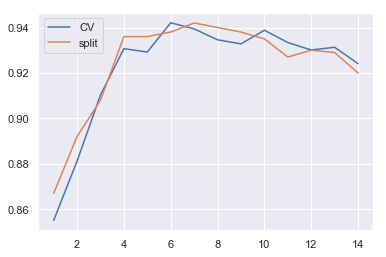

In [88]:
plt.plot(max_depth_values, cv_scores, label="CV")
plt.plot(max_depth_values, split_scores, label="split");
plt.legend()

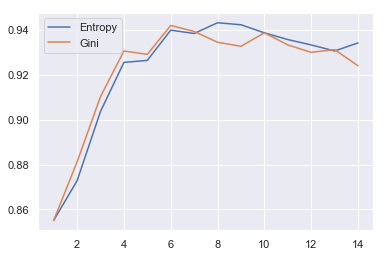

In [110]:
entr_scores = []
gini_scores = []

skf = StratifiedKFold(5, shuffle=True, random_state=17)
max_depth_values = np.arange(1,15)
for i in tqdm_notebook(max_depth_values):
    
    # Entropy
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=i, max_features=11, random_state=17)
    score = cross_val_score(estimator=tree, X=x, y=y, cv=skf).mean()
    entr_scores.append(score)
    
    # Gini
    tree = DecisionTreeClassifier(criterion="gini", max_depth=i, max_features=11, random_state=17)
    score = cross_val_score(estimator=tree, X=x, y=y, cv=skf).mean()
    gini_scores.append(score)

plt.plot(max_depth_values, entr_scores, label="Entropy")
plt.plot(max_depth_values, gini_scores, label="Gini");
plt.legend()